In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from google.colab import drive

drive.mount('/content/drive')

# PATH TO FILE LOCATION IN YOUR GOOGLE DRIVE
DIRPATH = '/content/drive/MyDrive/2022_summer-kf/'
FILEPATH = DIRPATH + 'p0_fish0_137_20210426.h5'

Mounted at /content/drive


# Load data

In [ ]:
df = pd.read_hdf(FILEPATH)

keypoint_names = ['snout', 'midbody', 'sidebody', 'endbody', 'tail', 'fan']
N = len(df)
K = len(keypoint_names)
D = 2

# Allocate array of desired shape, then fill
arr_df = np.empty((N, K, D), dtype=np.float32)
for i, dimstr in enumerate(['x', 'y']):
    arr_df[:, :, i] = df[[dimstr + '_' + kp_name for kp_name in keypoint_names]].to_numpy()

print(f'Keypoint array shape (N,K,D) = {arr_df.shape}')

Keypoint array shape (N,K,D) = (1723656, 6, 2)


In [ ]:
def plot_hist_nan_keypoints_and_frames(kp, kp_names=keypoint_names):
    is_keypoint_visible = np.isnan(kp[...,0]) # shape (N, K)
    K = kp.shape[-2]

    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,2))

    # Number of visible keypoints in a frame
    num_nans_per_frame = np.sum(is_keypoint_visible, axis=-1) # shape (N,)

    axs[0].hist(K-num_nans_per_frame, bins=np.arange(K+2),
            color='0.4', align='left', rwidth=0.8)
    axs[0].set_xlabel('# visible keypoints')
    axs[0].set_ylabel('# frames')
    axs[0].set_title('# visible keypoints per frame')

    # Number of missing frames for each keypoint
    num_nans_per_keypoint = np.sum(is_keypoint_visible, axis=0) # shape (K,)
    axs[1].bar(np.arange(K), num_nans_per_keypoint, color='0.4')
    axs[1].set_xticks(np.arange(K))
    axs[1].set_xticklabels(kp_names)
    axs[1].set_ylabel('# frames')
    axs[1].set_title('# missing frames by keypoints')

    for ax in axs:
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False);
        ax.set_yscale('log')

    return fig, num_nans_per_frame, num_nans_per_keypoint

Text(0.5, 1.1, 'Original data')

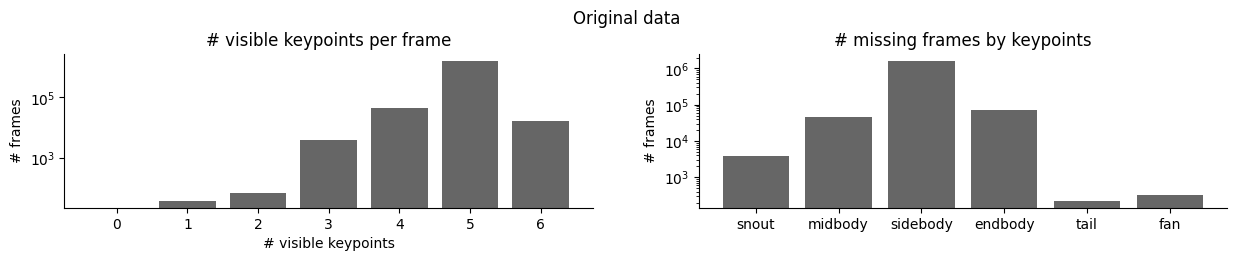

In [ ]:
fig, num_nans_per_frame, num_nans_per_keypoint \
    = plot_hist_nan_keypoints_and_frames(arr_df)

fig.suptitle('Original data', y=1.1)

Text(0.5, 1.1, 'After removing frames with <=3 visible keypoints')

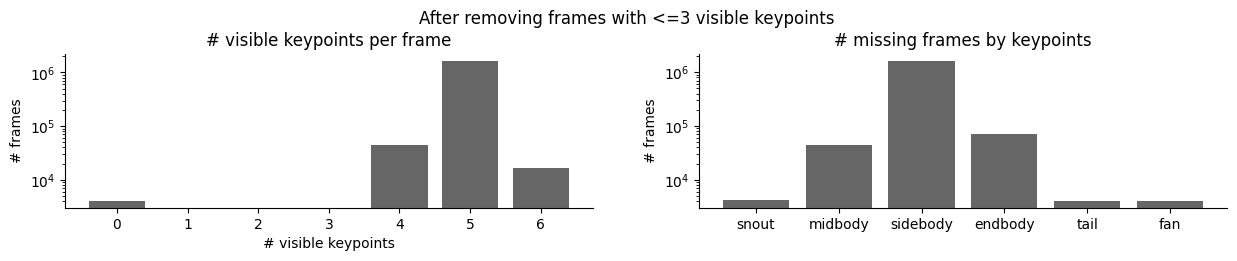

In [ ]:
# Let's remove frames with <=3 keypoints visible, since these frames are likely erroneous
i_remove = (num_nans_per_frame >= 3) # bool, shape (N,)
arr_pp = np.where(i_remove[:,None,None], np.nan*np.ones((N,K,D)), arr_df)

fig, _, _ = plot_hist_nan_keypoints_and_frames(arr_pp)
fig.suptitle('After removing frames with <=3 visible keypoints', y=1.1)

['snout', 'midbody', 'endbody', 'tail', 'fan']


(<Figure size 1500x200 with 2 Axes>,
 array([0, 0, 0, ..., 0, 0, 0]),
 array([ 3809, 44954, 71983,   226,   329]))

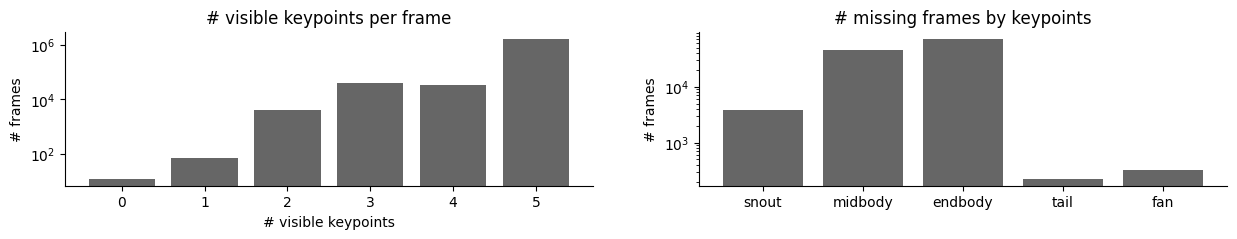

In [ ]:
# How many frames have all visible keypoints if we remove sidebody keypoint
k_keep = [0,1,3,4,5] # All keypoints except sidebody
print([keypoint_names[k] for k in k_keep])
plot_hist_nan_keypoints_and_frames(arr_df[:,k_keep,:],
                                  [keypoint_names[k] for k in k_keep])

# Prepare the data

## Center and normalize the data

In [ ]:
def standardize_data(X, axis=0):
    """Transforms data array X to have mean 0 and variance 1."""

    mean = np.nanmean(X, axis=axis)
    stdv = np.nanstd(X, axis=axis)

    return (X-mean)/stdv

arr_st = standardize_data(arr_pp)

# Check (assert) that arr_st has mean 0 and standard deviation 1
with np.printoptions(formatter={'all': '{:.2e}'.format}):
    assert np.allclose(np.nanmean(arr_st, axis=0), 0, atol=1e-1), \
        f'Expected standardized data to have mean 0, got {np.nanmean(arr_st, axis=0)}'
    assert np.allclose(np.nanstd(arr_st, axis=0), 1, atol=1e-1), \
        f'Expected standardized data to have standard deviation of 1, got {+ np.nanstd(arr_st, axis=0)}'

In [ ]:
with np.printoptions(formatter={'all': '{:.2e}'.format}):
    print(f'Original data mean `arr_pp`: \n{np.nanmean(arr_pp, axis=0)}')
    print(f'Standardized data mean `arr_st`: \n{np.nanmean(arr_st, axis=0)}')

    print()
    print(f'Original data std `arr_pp`: \n{np.nanstd(arr_pp, axis=0)}')
    print(f'Standardized data std `arr_st`: \n{np.nanstd(arr_st, axis=0)}')

Original data mean `arr_pp`: 
[[2.01e+02 1.00e+02]
 [2.06e+02 9.99e+01]
 [2.35e+02 9.57e+01]
 [2.14e+02 9.90e+01]
 [2.19e+02 9.87e+01]
 [2.24e+02 9.88e+01]]
Standardized data mean `arr_st`: 
[[-8.19e-16 8.40e-17]
 [1.40e-15 -4.23e-16]
 [1.93e-16 1.03e-16]
 [6.95e-17 4.09e-15]
 [2.64e-15 -4.11e-16]
 [1.10e-16 8.06e-16]]

Original data std `arr_pp`: 
[[9.98e+01 3.87e+01]
 [9.26e+01 3.44e+01]
 [1.09e+02 2.90e+01]
 [8.47e+01 3.04e+01]
 [8.28e+01 3.10e+01]
 [8.22e+01 3.43e+01]]
Standardized data std `arr_st`: 
[[1.00e+00 1.00e+00]
 [1.00e+00 1.00e+00]
 [1.00e+00 1.00e+00]
 [1.00e+00 1.00e+00]
 [1.00e+00 1.00e+00]
 [1.00e+00 1.00e+00]]


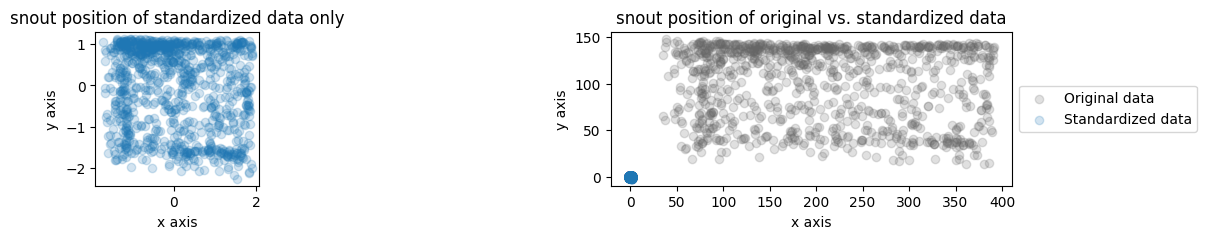

In [ ]:
# Select a random subset of frames and plot all keypoints
from numpy.random import default_rng
rng = default_rng()

n_samples = 1000

k = 0
i_rand_orig = rng.choice(N, size=n_samples, replace=False)
i_rand_stnd = rng.choice(N, size=n_samples, replace=False)

subarr_orig = arr_pp[i_rand_orig, k]
subarr_stnd = arr_st[i_rand_stnd, k]
# -------------------------------------------------------
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,2))

axs[0].scatter(subarr_stnd[...,0], subarr_stnd[...,1],
            alpha=0.2, color='C0', label='Standardized data')
axs[0].set_title(f'{keypoint_names[k]} position of standardized data only')

axs[1].scatter(subarr_orig[...,0], subarr_orig[...,1],
            alpha=0.2, color='0.4', label='Original data')
axs[1].scatter(subarr_stnd[...,0], subarr_stnd[...,1],
            alpha=0.2, color='C0', label='Standardized data')
axs[1].set_title(f'{keypoint_names[k]} position of original vs. standardized data')

plt.legend(bbox_to_anchor=[1,0.5], loc='center left')

for ax in axs:
    ax.set_xlabel('x axis'); ax.set_ylabel('y axis')
    ax.set_aspect('equal')

# Perform PCA

1. Covariance matrix of the data
2. Eigenvectors and eigenvalues of the covariance matrix
3. Calculate scores $S = X W$
4. Reconstruct data with PCs: $\hat{X}_r = S W_r^T$
5. Evaluate reconstruction error $X - \hat{X}_r$
6. Return $\hat{X}_r$ for desired $r$-dimensionality

Data shape:  (1723656, 6, 2)
Data flattened shape:  (1723656, 12)
Data flattened and transposed shape:  (12, 1723656)


Text(0.5, 1.01, 'Sample data covariance matrix')

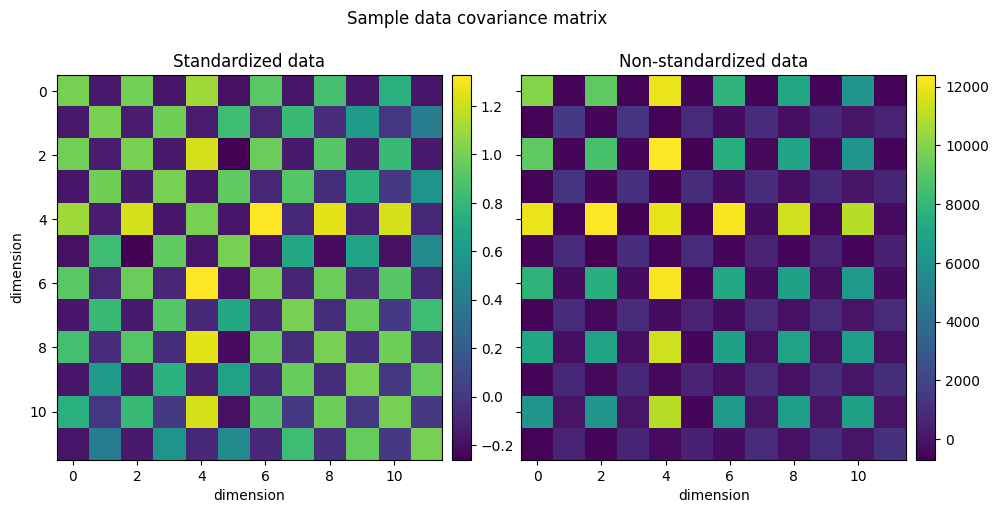

In [ ]:
# Calculate covariance matrix of the data
def nancov(X):
    """Compute sample covariance matrix of data X which contains NaNs.
    Source: https://stackoverflow.com/questions/53750371/how-to-calculate-np-cov-on-a-matrix-with-np-nan-values-without-converting-to-pd
    """
    ma_cov = np.ma.cov(np.ma.masked_invalid(X))
    return ma_cov.filled(np.nan)

print('Data shape: ', arr_st.shape)
print('Data flattened shape: ', arr_st.reshape(-1, K*D).shape)
print('Data flattened and transposed shape: ', arr_st.reshape(-1, K*D).T.shape)

# np.cov expects each row (axis=0) to represent a variable, with obs in columns
arr_st_flat = arr_st.reshape(-1, K*D)
cov_st = nancov(arr_st_flat.T)
cov_pp = nancov(arr_pp.reshape(-1,K*D).T)

# -------------------------------------------------------
# Plot covariance matrices of standardized and non-standardized data
# with shared colorbar
from mpl_toolkits.axes_grid1 import AxesGrid

fig = plt.figure(figsize=(15, 5))
grid = AxesGrid(fig, 111, nrows_ncols=(1,2), axes_pad=0.5,
                cbar_mode='each', cbar_location='right', cbar_pad=0.1)

vmin = np.min([np.nanmin(cov_st), np.nanmin(cov_pp)])
vmax = np.max([np.nanmax(cov_st), np.nanmax(cov_pp)])
for ax, arr in zip(grid, [cov_st, cov_pp]):
    im = ax.imshow(arr)
    ax.cax.colorbar(im)

    ax.set_xlabel('dimension')
    ax.set_ylabel('dimension')

grid[0].set_title('Standardized data')
grid[1].set_title('Non-standardized data')
fig.suptitle('Sample data covariance matrix', y=1.01)

In [ ]:
print(arr_st_flat)

[[-0.91669197  1.10275913 -0.87888787 ...  0.49257325 -0.5299375
   0.20622001]
 [-0.93949044  1.08022208 -0.90389656 ...  0.53818749 -0.60171094
   0.21374404]
 [-0.95867638  1.08705566 -0.92684136 ...  0.56439487 -0.5997866
   0.25121401]
 ...
 [-1.1845093  -1.38430854 -1.16903356 ...  0.00914947 -1.38462141
   0.57671681]
 [-1.19507423 -1.48605573 -1.1964812  ... -0.14645989 -1.29319458
   0.47538147]
 [-1.19671438 -1.50044866 -1.20693533 ... -0.31736929 -1.1973946
   0.35868414]]


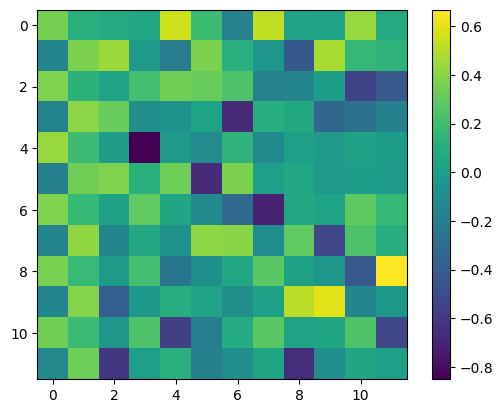

In [ ]:
# Find the eigenvalue and eigenvectors of the covariance matrix
eigvals_st, eigvecs_st = np.linalg.eig(cov_st)

im = plt.imshow(eigvecs_st)
plt.colorbar(im)

In [ ]:
eigvals_st, eigvecs_st = np.linalg.eig(cov_st)

print(eigvals_st, eigvecs_st)

[ 6.40314495e+00  4.56719643e+00  9.74716365e-01 -5.17432518e-01
  3.60518594e-01  2.02530768e-01 -4.36588799e-02  3.01574051e-02
  2.22033390e-02 -2.84729261e-03  1.53732086e-03  1.96403237e-03] [[ 3.56118025e-01  1.11830136e-01  7.91035818e-02  5.87374263e-02
   5.57366495e-01  1.89187581e-01 -1.77612131e-01  5.25388061e-01
   3.46165751e-02  2.25812165e-02  4.33823218e-01  8.38312222e-02]
 [-1.51168375e-01  3.67139538e-01  4.44731084e-01 -3.69947772e-02
  -2.08346943e-01  3.66937314e-01  1.16057321e-01 -5.47109717e-02
  -4.30246999e-01  4.68785105e-01  1.58256545e-01  1.37008062e-01]
 [ 3.72611165e-01  1.26017492e-01  3.19894876e-02  2.11159578e-01
   3.37664328e-01  3.12172179e-01  2.41057040e-01 -1.69777968e-01
  -1.58104256e-01 -3.32474173e-03 -5.43452046e-01 -4.25345691e-01]
 [-1.66753880e-01  4.04291509e-01  3.17038478e-01 -1.07817222e-01
  -7.80268448e-02  3.23658936e-02 -6.63646160e-01  1.06824745e-01
   7.26345502e-02 -3.49221894e-01 -2.77915641e-01 -1.82102348e-01]
 [ 4.349

In [ ]:
# Calculate score S = XW
def nanmatmul(X, W):
    """Compute sample covariance matrix of data X which contains NaNs.
    Source: https://stackoverflow.com/questions/53750371/how-to-calculate-np-cov-on-a-matrix-with-np-nan-values-without-converting-to-pd
    """
    X_0 = np.where(np.isnan(X), 0., X)
    return X_0 @ W

In [ ]:
# Reconstruct X_hat = S W_r.T
r = 11

scores_pca = nanmatmul(arr_st_flat, eigvecs_st[:, :r])
x_hat = scores_pca @ eigvecs_st[:,:r].T
x_hat.shape

(1723656, 12)

In [ ]:
# np.linalg.norm(x, p=2) == np.sqrt(|sum_i x_i^2|)
def nannorm(a,b, axis=-1):
    # a, b have shape (N,D)
    return np.sqrt(np.nansum((a-b)**2, axis=axis))
err = np.mean(nannorm(arr_st_flat, x_hat))
err

0.03468461152274983

1.169905876693539
[3.0238155747312683, 2.1719590202325327, 1.169905876693539, 0.8525257759130013, 0.7294611384409304, 0.5010880836927134, 0.37449071466837336, 0.23905006158734765, 0.16882206581324333, 0.09390272503939893, 0.04957586287211325, 0.03468461152274983]


Text(0, 0.5, 'error')

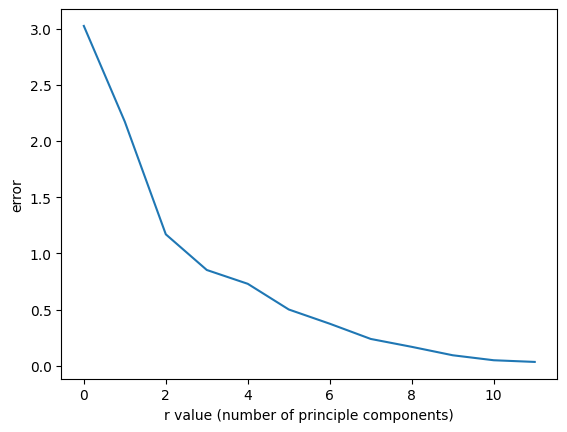

In [ ]:
r = [i for i in range(12)]
def eval(r: int):
    """Evaluate PCA fit with with r PCs.
    """

    # Calculate PC score
    score = nanmatmul(arr_st_flat, eigvecs_st[:, :r])

    # Reconstruct data
    X_hat = score @ eigvecs_st[:,:r].T

    # Evaluate 2-norm (Euclidean distance)
    err = np.mean(nannorm(arr_st_flat, X_hat))

    return err

# Evaluate PCA fit for r=1...D
print(eval(2))
pca_fit = []
for i in range(12):
  pca_fit.append(eval(i))
print(pca_fit)

# Plot reconstruction error vs r

plt.figure()
plt.plot(r, pca_fit)
plt.xlabel('r value (number of principle components)')
plt.ylabel('error')

# Autoencoders

In [ ]:
#@title Libraries

import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp
import jax
from jax import vmap, grad
import jax.random as jr
import time
import tqdm

import array
import gzip
import os
from os import path
import struct
import urllib.request

from sklearn.decomposition import PCA

In [ ]:
#@title Batching and Flattening
'''

#Using First 100k Data Pts

#flatten into 12-d vectors
x = arr_st_flat[:100000, :]
x = jnp.where(jnp.isnan(x), 0., x)
print(x.shape)

#batching
x_batched = jnp.array_split(x, 3125)
print(x_batched[0].shape)
'''

<ipython-input-21-ad3a550f9787>:7: DeprecationWarning: ml_dtypes.float8_e4m3b11 is deprecated. Use ml_dtypes.float8_e4m3b11fnuz
  x = jnp.where(jnp.isnan(x), 0., x)


(100000, 12)
(32, 12)


In [ ]:
#Using All 1.7mil Data Pts

x = arr_st_flat
x = jnp.where(jnp.isnan(x), 0., x)

#batching
x_batched = jnp.array_split(x, 39174)
print(x_batched[0].shape)

(44, 12)


In [ ]:
#@title Re-writing previous methods w/ jax
# Calculate score S = XW
def nanmatmul(X, W):
    """Compute sample covariance matrix of data X which contains NaNs.
    Source: https://stackoverflow.com/questions/53750371/how-to-calculate-np-cov-on-a-matrix-with-np-nan-values-without-converting-to-pd
    """
    X_0 = jnp.where(jnp.isnan(X), 0., X)
    return X_0 @ W

# np.linalg.norm(x, p=2) == np.sqrt(|sum_i x_i^2|)
def nannorm(a,b, axis=-1):
    # a, b have shape (N,D)
    return jnp.sqrt(jnp.nansum((a-b)**2, axis=axis))
err = jnp.mean(nannorm(arr_st_flat, x_hat))
err

Array(0.03468461, dtype=float32)

In [ ]:
#@title Parameter Initialization and Loss Function
latent_dim = 4
data_dim = 12

def initialize(latent_dim):
  W_1 = jr.normal(jr.PRNGKey(0), (data_dim, latent_dim))
  b_1 = jr.normal(jr.PRNGKey(1), (latent_dim,))
  W_2 = jr.normal(jr.PRNGKey(2), (latent_dim, data_dim))
  b_2 = jr.normal(jr.PRNGKey(3), (data_dim,))
  return([W_1, b_1, W_2, b_2])

def initialize_nl(latent_dim, neur_dim):
  #encoding
  W_1 = jr.normal(jr.PRNGKey(0), (data_dim, neur_dim)) / neur_dim
  b_1 = jr.normal(jr.PRNGKey(1), (neur_dim,))
  W_2 = jr.normal(jr.PRNGKey(2), (neur_dim, latent_dim)) / neur_dim
  b_2 = jr.normal(jr.PRNGKey(3), (latent_dim,))

  #decoding
  W_3 = jr.normal(jr.PRNGKey(4), (latent_dim, neur_dim)) / neur_dim
  b_3 = jr.normal(jr.PRNGKey(5), (neur_dim,))
  W_4 = jr.normal(jr.PRNGKey(6), (neur_dim, data_dim)) / neur_dim
  b_4 = jr.normal(jr.PRNGKey(7), (data_dim,))
  return([W_1, b_1, W_2, b_2, W_3, b_3, W_4, b_4])

def loss(data, params):
  def transform(data):
    z = data @ params[0] + params[1]
    x_hat = z @ params[2] + params[3]
    return x_hat
  x_hat = vmap(transform)(data)
  return jnp.mean(nannorm(data, x_hat))

def nonlin_loss_relu(data, params):
  def nonlin_transform_relu(data):
    z1 = jax.nn.relu(data @ params[0] + params[1])
    z = z1 @ params[2] + params[3]
    z2 = jax.nn.relu(z @ params[4] + params[5])
    x_hat = jax.nn.tanh(z2 @ params[6] + params[7])
    return x_hat
  x_hat = vmap(nonlin_transform_relu)(data)
  return jnp.mean((data - x_hat) ** 2)

In [ ]:
#@title Training

theta = initialize(4)

print(f"intial loss (random initialization): {loss(x, theta)}")

#linear traning
def train_step(data, params, lr):
  def l(params):
    return loss(data, params)

  g = grad(l)(params)

  for i in range(len(params)):
    params[i] -= g[i] * lr

  return params

train_step_jit = jax.jit(train_step)

#non-linear traning - relu
def nonlin_train_step_relu(data, params, lr):
  def l(params):
    return nonlin_loss_relu(data, params)

  g = grad(l)(params)

  for i in range(len(params)):
    params[i] -= g[i] * lr

  return params

nonlin_train_step_relu_jit = jax.jit(nonlin_train_step_relu)

intial loss (random initialization): 20.501089096069336


In [ ]:
#@title Function for Plotting

def plot_steps_loss(n_dim, n_steps, lr, col, lab):
  theta = initialize(n_dim)
  losses = []
  for i in range(n_steps):
    for j in range(len(x_batched)):
      theta = train_step_jit(x_batched[j],theta,lr)
    losses.append(loss(x,theta))
  plt.plot([k for k in range(n_steps)], losses, color = col, marker = 'o', label = lab)
  return theta, losses

def nonlin_plot_steps_loss_relu(latent_dim, n_steps, lr, neur_dim, col, lab):
  theta = initialize_nl(latent_dim, neur_dim)
  losses = []
  for i in range(n_steps):
    for j in range(len(x_batched)):
      theta = nonlin_train_step_relu_jit(x_batched[j],theta,lr)
    losses.append(nonlin_loss_relu(x,theta))
  plt.plot([k for k in range(n_steps)], losses, color = col, marker = 'o', label = lab)
  return theta, losses

Minimum Loss: 0.22918179631233215


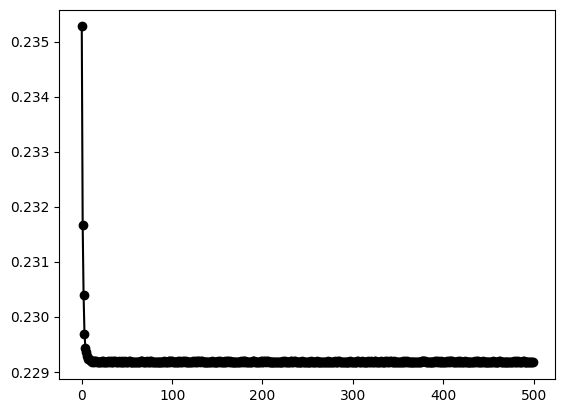

In [ ]:
#@title Loss Function - Linear AE
latent_dim = 4
n_steps = 500
lr = 0.01

ltheta, llosses = plot_steps_loss(latent_dim, n_steps, lr, 'k', '')
print(f"Minimum Loss: {llosses[-1]}")

In [ ]:
#@title Function to Compare PCA and Linear AE Losses - PCA Wins
def all_loss(x, x_hat):
  np.mean(nannorm(x, x_hat))

params = ltheta
z = x @ params[0] + params[1]
x_hat = z @ params[2] + params[3]

print(f"Linear AE Loss: {loss(x, x_hat)}")

# Calculate PC score
score = nanmatmul(arr_st_flat, eigvecs_st[:, :4])

# Reconstruct data
x_hat = score @ eigvecs_st[:,:4].T

print(f"PCA Loss: {loss(x, x_hat)}")

Linear AE Loss: 22.85413360595703
PCA Loss: 20.257925033569336


Minimum Loss: 0.08213082700967789


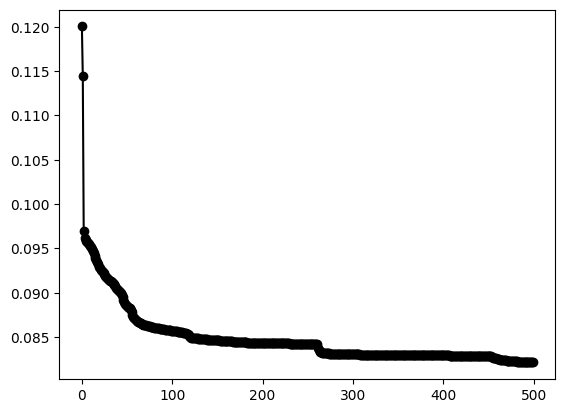

In [ ]:
#@title Loss Function - Nonlinear AE
latent_dim = 4
n_steps = 500
lr = 0.01
neur_dim = 10

ntheta, nlosses = nonlin_plot_steps_loss_relu(latent_dim, n_steps, lr, neur_dim, 'k', '')
print(f"Minimum Loss: {nlosses[-1]}")

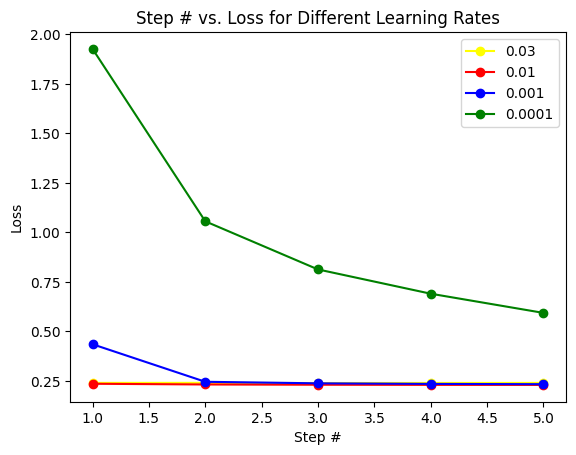

In [ ]:
#@title Loss Curve - Linear Learning Rate Comparisons

latent_dim = 4
n_steps = 5

#lr of 0.03
lr = 0.03

#initialize
theta = initialize(latent_dim)

plt.figure()
plt.title("Step # vs. Loss for Different Learning Rates")
plt.xlabel("Step #")
plt.ylabel("Loss")

losses = []
for i in range(n_steps):
  for j in range(len(x_batched)):
    theta = train_step_jit(x_batched[j],theta,lr)
  losses.append(loss(x,theta))
plt.plot([k for k in range(1, n_steps + 1)], losses, color = 'yellow', marker = 'o', label = '0.03')

#lr of 0.01
lr = 0.01

#re-initialize
theta = initialize(latent_dim)

losses = []
for i in range(n_steps):
  for j in range(len(x_batched)):
    theta = train_step_jit(x_batched[j],theta,lr)
  losses.append(loss(x,theta))
plt.plot([k for k in range(1, n_steps + 1)], losses, color = 'red', marker = 'o', label = '0.01')

#lr of 0.001
lr = 0.001

#re-initialize
theta = initialize(latent_dim)

losses = []
for i in range(n_steps):
  for j in range(len(x_batched)):
    theta = train_step_jit(x_batched[j],theta,lr)
  losses.append(loss(x,theta))
plt.plot([k for k in range(1, n_steps + 1)], losses, color = 'blue', marker = 'o', label = '0.001')

#lr of 0.0001
lr = 0.0001

#re-initialize
theta = initialize(latent_dim)

losses = []
for i in range(n_steps):
  for j in range(len(x_batched)):
    theta = train_step_jit(x_batched[j],theta,lr)
  losses.append(loss(x,theta))
plt.plot([k for k in range(1, n_steps + 1)], losses, color = 'green', marker = 'o', label = '0.0001')

plt.legend()
plt.show()

# Animations

In [ ]:
#@title Original & Linear Data Prep
data = x
n_samples = 1723656
print(data.shape)
params = ltheta
z = data @ params[0] + params[1]
x_hat = z @ params[2] + params[3]

x_hat = x_hat.reshape(n_samples,6,2)

(1723656, 12)


<ipython-input-83-5dda4dedb083>:23: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "g." (-> color='g'). The keyword argument will take precedence.
  pt0, = axis.plot([], [], 'g.', color = 'red', ms=20, label = 'Snout')
<ipython-input-83-5dda4dedb083>:24: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "g." (-> color='g'). The keyword argument will take precedence.
  pt1, = axis.plot([], [], 'g.', color = 'orange', ms=20, label = 'Midbody')
<ipython-input-83-5dda4dedb083>:25: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "g." (-> color='g'). The keyword argument will take precedence.
  pt2, = axis.plot([], [], 'g.', color = 'yellow', ms=20, label = 'Sidebody')
<ipython-input-83-5dda4dedb083>:26: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "g." (-> color='g'). The keyword argument will take precedence.
 

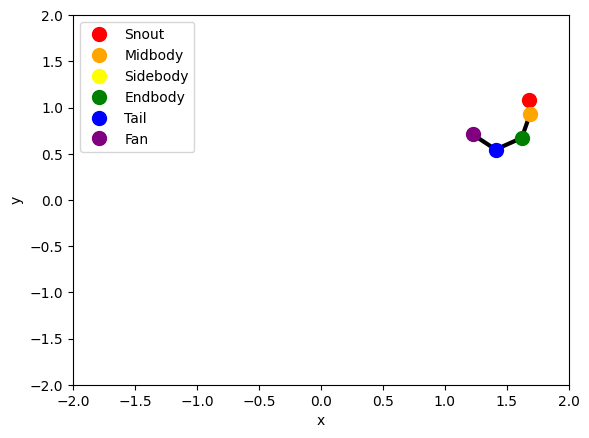

In [ ]:
#@title Old Animation

#all keypoints - skeleton animation (day)
from matplotlib import pyplot as plt
import numpy as np
from matplotlib.animation import FuncAnimation

# initializing a figure
fig = plt.figure()

# marking the x-axis and y-axis
axis = plt.axes(xlim =(-2, 2),
                ylim =(-2, 2))

# initializing a line variable
line0, = axis.plot([], [], lw = 3, color = 'black')
line1, = axis.plot([], [], lw = 3, color = 'black')
line2, = axis.plot([], [], lw = 3, color = 'black')
line3, = axis.plot([], [], lw = 3, color = 'black')
line4, = axis.plot([], [], lw = 3, color = 'black')
line5, = axis.plot([], [], lw = 3, color = 'black')

pt0, = axis.plot([], [], 'g.', color = 'red', ms=20, label = 'Snout')
pt1, = axis.plot([], [], 'g.', color = 'orange', ms=20, label = 'Midbody')
pt2, = axis.plot([], [], 'g.', color = 'yellow', ms=20, label = 'Sidebody')
pt3, = axis.plot([], [], 'g.', color = 'green', ms=20, label = 'Endbody')
pt4, = axis.plot([], [], 'g.', color = 'blue', ms=20, label = 'Tail')
pt5, = axis.plot([], [], 'g.', color = 'purple', ms=20, label = 'Fan')

# data which the line will contain (x, y)
def init():
    line0.set_data([], [])
    line1.set_data([], [])
    line2.set_data([], [])
    line3.set_data([], [])
    line4.set_data([], [])
    pt0.set_data([], [])
    pt1.set_data([], [])
    pt2.set_data([], [])
    pt3.set_data([], [])
    pt4.set_data([], [])
    pt5.set_data([], [])
    return line0,line1,line2,line3,line4,line5

def animate(i):
    x0 = arr_st[:1000, 0, 0]
    y0 = arr_st[:1000, 0, 1]
    x1 = arr_st[:1000, 1, 0]
    y1 = arr_st[:1000, 1, 1]
    x2 = arr_st[:1000, 2, 0]
    y2 = arr_st[:1000, 2, 1]
    x3 = arr_st[:1000, 3, 0]
    y3 = arr_st[:1000, 3, 1]
    x4 = arr_st[:1000, 4, 0]
    y4 = arr_st[:1000, 4, 1]
    x5 = arr_st[:1000, 5, 0]
    y5 = arr_st[:1000, 5, 1]
    x01vals = [x0[i], x1[i]]
    y01vals = [y0[i], y1[i]]
    x12vals = [x1[i], x2[i]]
    y12vals = [y1[i], y2[i]]
    x23vals = [x2[i], x3[i]]
    y23vals = [y2[i], y3[i]]
    x34vals = [x3[i], x4[i]]
    y34vals = [y3[i], y4[i]]
    x45vals = [x4[i], x5[i]]
    y45vals = [y4[i], y5[i]]

    x13vals = [x1[i], x3[i]]
    y13vals = [y1[i], y3[i]]

    line0.set_data(x01vals,y01vals)
    line1.set_data(x12vals,y12vals)
    line2.set_data(x23vals,y23vals)
    line3.set_data(x34vals,y34vals)
    line4.set_data(x45vals,y45vals)
    line5.set_data(x13vals,y13vals)

    pt0.set_data(x0[i],y0[i])
    pt1.set_data(x1[i],y1[i])
    pt2.set_data(x2[i],y2[i])
    pt3.set_data(x3[i],y3[i])
    pt4.set_data(x4[i],y4[i])
    pt5.set_data(x5[i],y5[i])
    return line0,line1,line2,line3,line4,line5

plt.legend()
plt.xlabel('x')
plt.ylabel('y')

anim = FuncAnimation(fig, animate, init_func = init, frames = 100, interval = 50, blit = True)

anim.save('KeypointMovement.mp4', writer = 'ffmpeg', fps = 30)

from IPython.display import HTML
HTML(anim.to_html5_video())

<ipython-input-63-8d153a6813ba>:23: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "g." (-> color='g'). The keyword argument will take precedence.
  pt0, = axis.plot([], [], 'g.', color = 'red', ms=20, label = 'Snout')
<ipython-input-63-8d153a6813ba>:24: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "g." (-> color='g'). The keyword argument will take precedence.
  pt1, = axis.plot([], [], 'g.', color = 'orange', ms=20, label = 'Midbody')
<ipython-input-63-8d153a6813ba>:26: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "g." (-> color='g'). The keyword argument will take precedence.
  pt2, = axis.plot([], [], 'g.', color = 'green', ms=20, label = 'Endbody')
<ipython-input-63-8d153a6813ba>:27: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "g." (-> color='g'). The keyword argument will take precedence.
  p

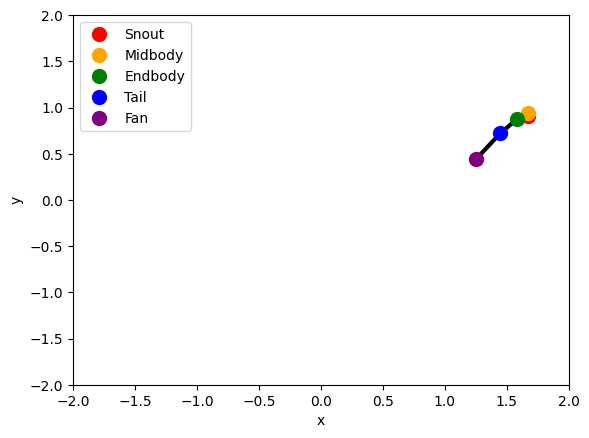

In [ ]:
#@title New Animation - Linear

#all keypoints - skeleton animation (day)
from matplotlib import pyplot as plt
import numpy as np
from matplotlib.animation import FuncAnimation

# initializing a figure
fig = plt.figure()

# marking the x-axis and y-axis
axis = plt.axes(xlim =(-2, 2),
                ylim =(-2, 2))

# initializing a line variable
line0, = axis.plot([], [], lw = 3, color = 'black')
line1, = axis.plot([], [], lw = 3, color = 'black')
line2, = axis.plot([], [], lw = 3, color = 'black')
line3, = axis.plot([], [], lw = 3, color = 'black')
line4, = axis.plot([], [], lw = 3, color = 'black')
#line5, = axis.plot([], [], lw = 3, color = 'black')

pt0, = axis.plot([], [], 'g.', color = 'red', ms=20, label = 'Snout')
pt1, = axis.plot([], [], 'g.', color = 'orange', ms=20, label = 'Midbody')
#pt2, = axis.plot([], [], 'g.', color = 'yellow', ms=20, label = 'Sidebody')
pt2, = axis.plot([], [], 'g.', color = 'green', ms=20, label = 'Endbody')
pt3, = axis.plot([], [], 'g.', color = 'blue', ms=20, label = 'Tail')
pt4, = axis.plot([], [], 'g.', color = 'purple', ms=20, label = 'Fan')

# data which the line will contain (x, y)
def init():
    line0.set_data([], [])
    line1.set_data([], [])
    line2.set_data([], [])
    line3.set_data([], [])
    line4.set_data([], [])
    pt0.set_data([], [])
    pt1.set_data([], [])
    pt2.set_data([], [])
    pt3.set_data([], [])
    pt4.set_data([], [])
    #pt5.set_data([], [])
    return line0,line1,line2,line3,line4

def animate(i):
    x0 = x_hat[:1000, 0, 0]
    y0 = x_hat[:1000, 0, 1]
    x1 = x_hat[:1000, 1, 0]
    y1 = x_hat[:1000, 1, 1]
    #remove sidebody for simplification
    #x2 = x_hat[:1000, 2, 0]
    #y2 = x_hat[:1000, 2, 1]

    x3 = x_hat[:1000, 3, 0]
    y3 = x_hat[:1000, 3, 1]
    x4 = x_hat[:1000, 4, 0]
    y4 = x_hat[:1000, 4, 1]
    x5 = x_hat[:1000, 5, 0]
    y5 = x_hat[:1000, 5, 1]
    x01vals = [x0[i], x1[i]]
    y01vals = [y0[i], y1[i]]
    #x12vals = [x1[i], x2[i]]
    #y12vals = [y1[i], y2[i]]

    #x23vals = [x2[i], x3[i]]
    #y23vals = [y2[i], y3[i]]

    x34vals = [x3[i], x4[i]]
    y34vals = [y3[i], y4[i]]

    x45vals = [x4[i], x5[i]]
    y45vals = [y4[i], y5[i]]

    x13vals = [x1[i], x3[i]]
    y13vals = [y1[i], y3[i]]

    line0.set_data(x01vals,y01vals)
    #line1.set_data(x12vals,y12vals)
    line1.set_data(x13vals,y13vals)
    #line2.set_data(x23vals,y23vals)
    line2.set_data(x34vals,y34vals)
    line3.set_data(x45vals,y45vals)

    pt0.set_data(x0[i],y0[i])
    pt1.set_data(x1[i],y1[i])
    #pt2.set_data(x2[i],y2[i])
    pt2.set_data(x3[i],y3[i])
    pt3.set_data(x4[i],y4[i])
    pt4.set_data(x5[i],y5[i])
    return line0,line1,line2,line3

plt.legend()
plt.xlabel('x')
plt.ylabel('y')

anim = FuncAnimation(fig, animate, init_func = init, frames = 100, interval = 50, blit = True)

anim.save('KeypointMovement.mp4', writer = 'ffmpeg', fps = 30)

from IPython.display import HTML
HTML(anim.to_html5_video())

In [ ]:
#@title Nonlinear Data Prep
data = x
print(data.shape)
params = ntheta
z1 = jax.nn.relu(data @ params[0] + params[1])
z = z1 @ params[2] + params[3]
z2 = jax.nn.relu(z @ params[4] + params[5])
x_hat = jax.nn.tanh(z2 @ params[6] + params[7])

x_hat = x_hat.reshape(1723656,6,2)

(1723656, 12)


<ipython-input-34-57d5f188d0b8>:23: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "g." (-> color='g'). The keyword argument will take precedence.
  pt0, = axis.plot([], [], 'g.', color = 'red', ms=20, label = 'Snout')
<ipython-input-34-57d5f188d0b8>:24: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "g." (-> color='g'). The keyword argument will take precedence.
  pt1, = axis.plot([], [], 'g.', color = 'orange', ms=20, label = 'Midbody')
<ipython-input-34-57d5f188d0b8>:26: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "g." (-> color='g'). The keyword argument will take precedence.
  pt2, = axis.plot([], [], 'g.', color = 'green', ms=20, label = 'Endbody')
<ipython-input-34-57d5f188d0b8>:27: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "g." (-> color='g'). The keyword argument will take precedence.
  p

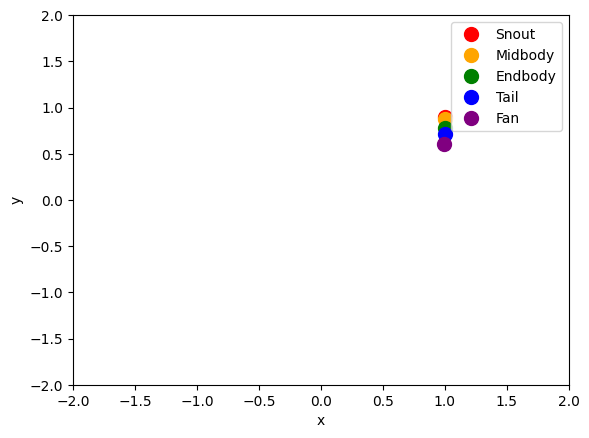

In [ ]:
#@title New Animation - Nonlinear

#all keypoints - skeleton animation (day)
from matplotlib import pyplot as plt
import numpy as np
from matplotlib.animation import FuncAnimation

# initializing a figure
fig = plt.figure()

# marking the x-axis and y-axis
axis = plt.axes(xlim =(-2, 2),
                ylim =(-2, 2))

# initializing a line variable
line0, = axis.plot([], [], lw = 3, color = 'black')
line1, = axis.plot([], [], lw = 3, color = 'black')
line2, = axis.plot([], [], lw = 3, color = 'black')
line3, = axis.plot([], [], lw = 3, color = 'black')
line4, = axis.plot([], [], lw = 3, color = 'black')
#line5, = axis.plot([], [], lw = 3, color = 'black')

pt0, = axis.plot([], [], 'g.', color = 'red', ms=20, label = 'Snout')
pt1, = axis.plot([], [], 'g.', color = 'orange', ms=20, label = 'Midbody')
#pt2, = axis.plot([], [], 'g.', color = 'yellow', ms=20, label = 'Sidebody')
pt2, = axis.plot([], [], 'g.', color = 'green', ms=20, label = 'Endbody')
pt3, = axis.plot([], [], 'g.', color = 'blue', ms=20, label = 'Tail')
pt4, = axis.plot([], [], 'g.', color = 'purple', ms=20, label = 'Fan')

# data which the line will contain (x, y)
def init():
    line0.set_data([], [])
    line1.set_data([], [])
    line2.set_data([], [])
    line3.set_data([], [])
    line4.set_data([], [])
    pt0.set_data([], [])
    pt1.set_data([], [])
    pt2.set_data([], [])
    pt3.set_data([], [])
    pt4.set_data([], [])
    #pt5.set_data([], [])
    return line0,line1,line2,line3,line4

def animate(i):
    x0 = x_hat[:1000, 0, 0]
    y0 = x_hat[:1000, 0, 1]
    x1 = x_hat[:1000, 1, 0]
    y1 = x_hat[:1000, 1, 1]
    #remove sidebody for simplification
    #x2 = x_hat[:1000, 2, 0]
    #y2 = x_hat[:1000, 2, 1]

    x3 = x_hat[:1000, 3, 0]
    y3 = x_hat[:1000, 3, 1]
    x4 = x_hat[:1000, 4, 0]
    y4 = x_hat[:1000, 4, 1]
    x5 = x_hat[:1000, 5, 0]
    y5 = x_hat[:1000, 5, 1]
    x01vals = [x0[i], x1[i]]
    y01vals = [y0[i], y1[i]]
    #x12vals = [x1[i], x2[i]]
    #y12vals = [y1[i], y2[i]]

    #x23vals = [x2[i], x3[i]]
    #y23vals = [y2[i], y3[i]]

    x34vals = [x3[i], x4[i]]
    y34vals = [y3[i], y4[i]]

    x45vals = [x4[i], x5[i]]
    y45vals = [y4[i], y5[i]]

    x13vals = [x1[i], x3[i]]
    y13vals = [y1[i], y3[i]]

    line0.set_data(x01vals,y01vals)
    #line1.set_data(x12vals,y12vals)
    line1.set_data(x13vals,y13vals)
    #line2.set_data(x23vals,y23vals)
    line2.set_data(x34vals,y34vals)
    line3.set_data(x45vals,y45vals)

    pt0.set_data(x0[i],y0[i])
    pt1.set_data(x1[i],y1[i])
    #pt2.set_data(x2[i],y2[i])
    pt2.set_data(x3[i],y3[i])
    pt3.set_data(x4[i],y4[i])
    pt4.set_data(x5[i],y5[i])
    return line0,line1,line2,line3

plt.legend()
plt.xlabel('x')
plt.ylabel('y')

anim = FuncAnimation(fig, animate, init_func = init, frames = 100, interval = 50, blit = True)

anim.save('KeypointMovement.mp4', writer = 'ffmpeg', fps = 30)

from IPython.display import HTML
HTML(anim.to_html5_video())